In [57]:
import numpy as np
import funciones_auxiliares as fa
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    GradientBoostingClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib
import os
import pandas as pd
import seaborn as sns
import zipfile

1. Identification and fitting process of classification models. (1.0 pts)

Obtenemos los datos

In [58]:
X_train = np.loadtxt("X_train", delimiter=",")
X_test = np.loadtxt("X_test", delimiter=",")
y_test = np.loadtxt("y_test", delimiter=",")
y_train = np.loadtxt("y_train", delimiter=",")

In [59]:
# columnas de los predictores
columnas_xx = [
    "ExternalRiskEstimate",
    "NetFractionRevolvingBurden",
    "AverageMInFile",
    "MSinceOldestTradeOpen",
    "PercentTradesWBalance",
    "PercentInstallTrades",
    "NumSatisfactoryTrades",
    "NumTotalTrades",
    "PercentTradesNeverDelq",
    "MSinceMostRecentInqexcl7days",
]

In [60]:
diccionario_performance = {}  # Diccionario para almacenar los modelos y su performance

***Fase de entrenamiento de los modelos*** 

Si se quiere omitir, no ejecute las siguentes celdas. 
Si se quiere actualizar un modelo de los almacenados en memoria, entonces entrene el modelo y cárguelo en memoria. 
Todos los modelos se almacenarán en diccionario_performance con la siguente estructura {'nombre modelo':[objeto modelo, acuraccy train, acuraccy test]}

**KNN**

Utilizamos validación cruzada para elegir los valores de los hiperparámetros k y p

Optimal value of k for p = 1: 33 with a score of 0.72


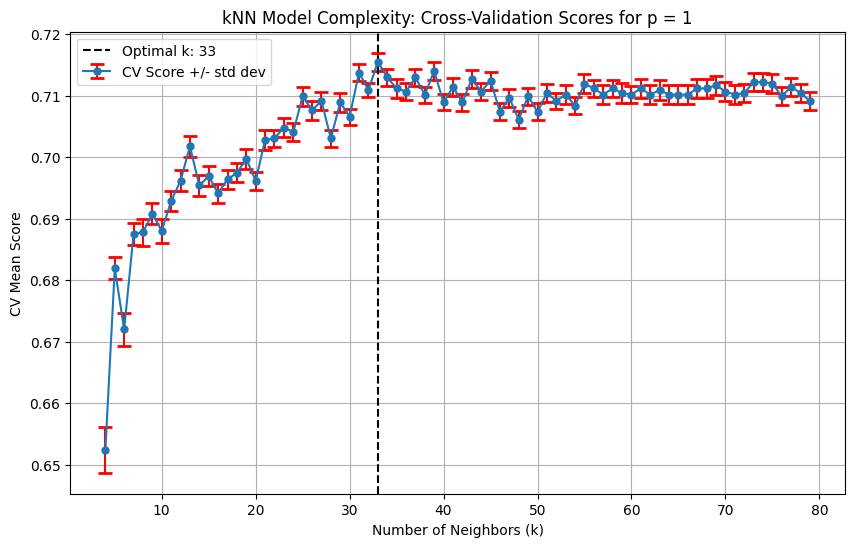

Optimal value of k for p = 2: 78 with a score of 0.71


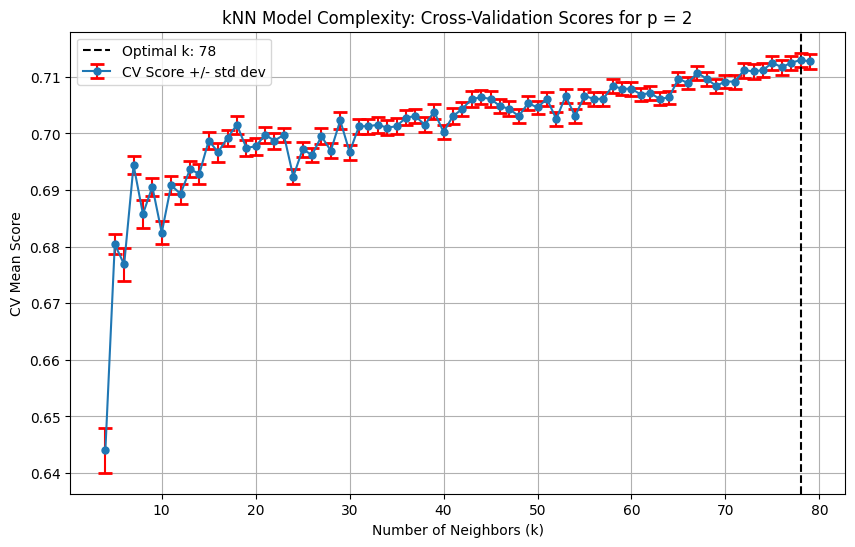

Optimal value of k for p = 3: 79 with a score of 0.71


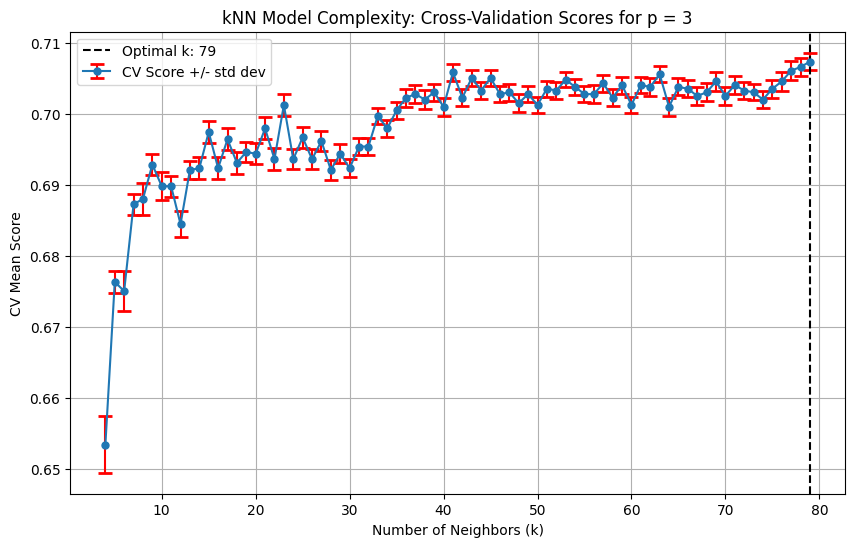

In [5]:
pvalues = [1, 2, 3]

hiperparameters_with_acuraccy = {}

for pvalue in pvalues:
    # Initialize lists to store mean scores and standard deviations for each value of k
    mean_scores = []
    std_scores = []
    # Define the range of k values to test
    k_values = range(4, 80)
    # TODO: Loop through each value of k, obtaining the mean accuracy score and the standard deviation of the accuracy score in cross validation
    means = np.array([])
    stds = np.array([])
    for k in k_values:
        model = KNeighborsClassifier(k, metric="minkowski", p=pvalue)
        mean_acuracy, std_acuracy = fa.cross_validationknn(model, X_train, y_train, 30)
        means = np.append(means, mean_acuracy)
        stds = np.append(stds, std_acuracy)
    # TODO: Find the highest score and the corresponding optimal k
    highest_score = np.max(means)
    optimal_k = k_values[np.where(means == highest_score)[0][0]]
    mean_scores = list(means)
    std_scores = list(stds)
    print(
        f"Optimal value of k for p = {pvalue}: {optimal_k} with a score of {highest_score:.2f}"
    )
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        k_values,
        mean_scores,
        yerr=std_scores,
        fmt="-o",
        ecolor="r",
        capsize=5,
        capthick=2,
        markersize=5,
        label="CV Score +/- std dev",
    )
    plt.axvline(x=optimal_k, linestyle="--", color="k", label=f"Optimal k: {optimal_k}")
    plt.title(f"kNN Model Complexity: Cross-Validation Scores for p = {pvalue}")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("CV Mean Score")
    plt.legend()
    plt.grid(True)
    plt.show()
    hiperparameters_with_acuraccy[highest_score] = {"k": optimal_k, "p": pvalue}

Obtenemos ahora los valores óptimos de k y p.

In [6]:
max_acurracy = max(hiperparameters_with_acuraccy.keys())
print(max_acurracy)
print(hiperparameters_with_acuraccy[max_acurracy])

0.7155216284987277
{'k': 33, 'p': 1}


Entrenamos el modelo óptimo

In [7]:
knn_model = KNeighborsClassifier(
    n_neighbors=hiperparameters_with_acuraccy[max_acurracy]["k"],
    metric="minkowski",
    p=hiperparameters_with_acuraccy[max_acurracy]["p"],
)
knn_model.fit(X_train, y_train)
acc_train = accuracy_score(y_train, knn_model.predict(X_train))
acc_test = accuracy_score(y_test, knn_model.predict(X_test))
print(f"Accuracy, train = {acc_train} test = {acc_test}")
diccionario_performance["KNeighborsClassifier"] = [knn_model, acc_train, acc_test]

Accuracy, train = 0.7456384323640961 test = 0.7246963562753036


No tiene mala pinta, el acuraccy en test es parecido al acuraccy en train, lo que indica que no hay overfitting significativo. 

**Regresión Logística**

In [8]:
model = LogisticRegression(
    penalty=None, max_iter=1000, solver="saga"
)  # cambiamos el solver para que sea compatible con la pérdida l1 y con elasticnet
model.fit(X_train, y_train)
predictionstest = model.predict(X_test)
accuracytest = accuracy_score(y_test, predictionstest)
predictionstrain = model.predict(X_train)
accuracytrain = accuracy_score(y_train, predictionstrain)
print(f"Accuracy, train = {accuracytrain} test = {accuracytest}")

Accuracy, train = 0.7350189633375475 test = 0.729757085020243


Vamos a hacer una especie de validación cruzada para encontrar la mejor regularización y el mejor parámetro de regularización

In [9]:
penalties = ["l2", "l1", "elasticnet"]


param_grid = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

for penalty in penalties:
    if penalty != "elasticnet":
        logistic = LogisticRegression(max_iter=1000, penalty=penalty, solver="saga")

    else:
        logistic = LogisticRegression(
            max_iter=1000, penalty=penalty, solver="saga", l1_ratio=0.5
        )

    grid_search = GridSearchCV(
        logistic, param_grid, cv=100, scoring="accuracy"
    )  # función para hacer cross-validation

    grid_search.fit(X_train, y_train)
    print(f"Penalty: {penalty}")
    print("Mejores parámetros encontrados:", grid_search.best_params_)
    print("Acuraccy train cross-validation", grid_search.best_score_)

Penalty: l2
Mejores parámetros encontrados: {'C': 0.01}
Acuraccy train cross-validation 0.7362307692307691
Penalty: l1
Mejores parámetros encontrados: {'C': 0.1}
Acuraccy train cross-validation 0.7339679487179488
Penalty: elasticnet
Mejores parámetros encontrados: {'C': 0.1}
Acuraccy train cross-validation 0.7347243589743591


Parece que el accuracy que podemos obtener en función del tipo de regularización no varía mucho. 

entrenamos el modelo óptimo.

In [10]:
logreg_model = LogisticRegression(max_iter=1000, penalty="l2", solver="saga", C=0.01)
logreg_model.fit(X_train, y_train)
predictionstest = logreg_model.predict(X_test)
accuracy_test = accuracy_score(y_test, predictionstest)
predictionstrain = logreg_model.predict(X_train)
accuracy_train = accuracy_score(y_train, predictionstrain)
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["LogisticRegression"] = [
    logreg_model,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.7372945638432364 test = 0.7246963562753036


**LDA**

In [11]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, lda_model.predict(X_test))
accuracy_train = accuracy_score(y_train, lda_model.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["LinearDiscriminantAnalysis"] = [
    lda_model,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.734007585335019 test = 0.7327935222672065


**QDA**

In [12]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, qda_model.predict(X_test))
accuracy_train = accuracy_score(y_train, qda_model.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")

Accuracy, train = 0.7099873577749684 test = 0.7135627530364372


Vamos a regularizar.

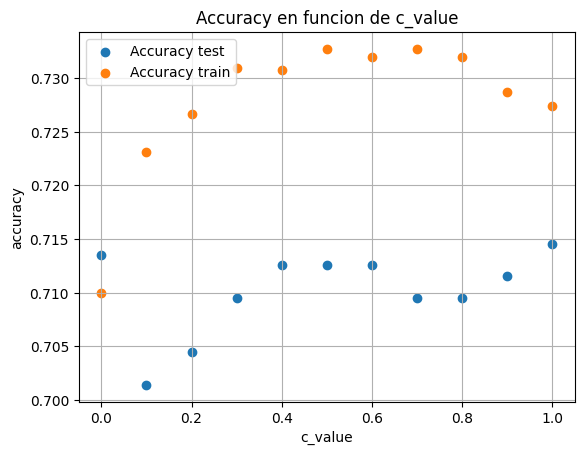

In [13]:
c_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
acc_test = []
acc_train = []
for c in c_values:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=c)
    qda_model.fit(X_train, y_train)
    accuracy_test = accuracy_score(y_test, qda_model.predict(X_test))
    accuracy_train = accuracy_score(y_train, qda_model.predict(X_train))
    acc_test.append(accuracy_test)
    acc_train.append(accuracy_train)
# Graficar los vectores
plt.scatter(c_values, acc_test, label="Accuracy test")
plt.scatter(c_values, acc_train, label="Accuracy train")
plt.xlabel("c_value")
plt.ylabel("accuracy")
plt.title("Accuracy en funcion de c_value")
plt.legend()
plt.grid(True)
plt.show()

c = 1 parece un buen valor. Entrenamos el modelo óptimo.

In [46]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=1)
qda_model.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, qda_model.predict(X_test))
accuracy_train = accuracy_score(y_train, qda_model.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["QuadraticDiscriminantAnalysis"] = [
    qda_model,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.727433628318584 test = 0.7145748987854251


**Gaussian Naive Bayes**

In [15]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, nb_model.predict(X_test))
accuracy_train = accuracy_score(y_train, nb_model.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["GaussianNB"] = [nb_model, accuracy_train, accuracy_test]

Accuracy, train = 0.7276864728192162 test = 0.7145748987854251


**Árbol de clasificación**

In [16]:
single_tree_classifier = DecisionTreeClassifier(
    random_state=0, max_depth=6, criterion="gini"
)
single_tree_classifier.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, single_tree_classifier.predict(X_test))
accuracy_train = accuracy_score(y_train, single_tree_classifier.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")

Accuracy, train = 0.7635903919089759 test = 0.7074898785425101


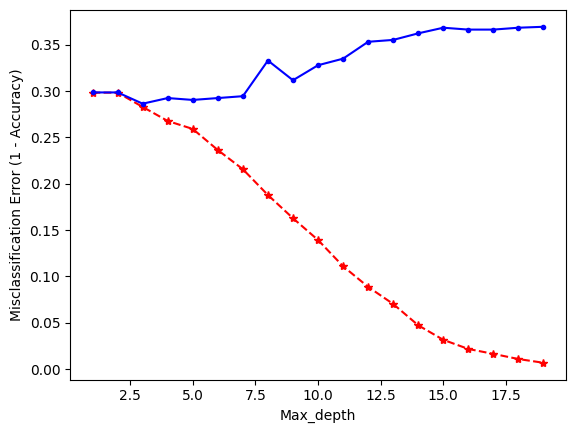

In [17]:
# Lists to store the results
train_gini = []
test_gini = []

# Range of depths to be explored
tree_size = np.arange(1, 20)

for i in tree_size:
    classifier = DecisionTreeClassifier(random_state=1, max_depth=i, criterion="gini")
    classifier.fit(X_train, y_train)
    predictionstest = classifier.predict(X_test)
    accuracytest = accuracy_score(y_test, predictionstest)
    predictionstrain = classifier.predict(X_train)
    accuracytrain = accuracy_score(y_train, predictionstrain)

    train_gini.append(1 - accuracytrain)
    test_gini.append(1 - accuracytest)

# Plot the results
plt.plot(tree_size, train_gini, "r*--")
plt.plot(tree_size, test_gini, "b.-")
plt.xlabel("Max_depth")
plt.ylabel("Misclassification Error (1 - Accuracy)")
plt.show()

entrenamos el óptimo

In [18]:
single_tree_classifier = DecisionTreeClassifier(
    random_state=0, max_depth=3, criterion="gini"
)
single_tree_classifier.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, single_tree_classifier.predict(X_test))
accuracy_train = accuracy_score(y_train, single_tree_classifier.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["DecisionTreeClassifier"] = [
    single_tree_classifier,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.7170670037926675 test = 0.7135627530364372


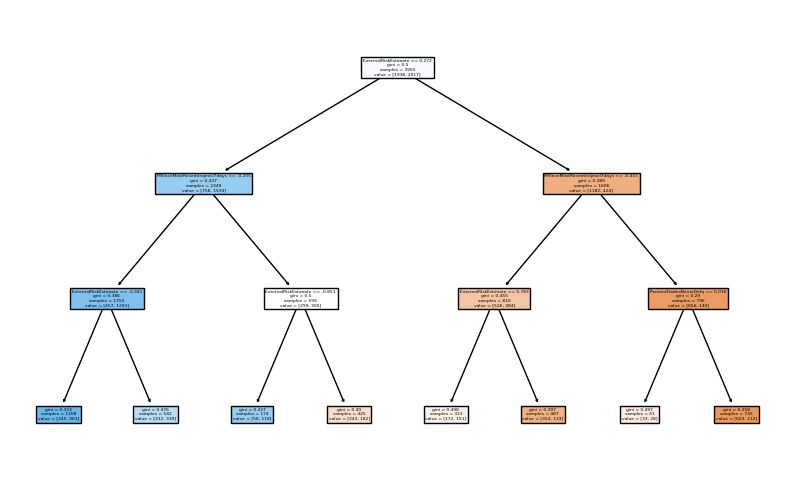

In [19]:
plt.figure(figsize=(10, 6))
plot_tree(single_tree_classifier, feature_names=columnas_xx, filled=True)
plt.show()

**Bagging**

Validación cruzada para elegir los hiperparámetros

In [20]:
# Definimos los parámetros que queremos probar en el BaggingClassifier
parameters = {
    "n_estimators": [10, 50, 100],  # Número de estimadores (clasificadores base)
    "max_samples": [
        0.5,
        0.75,
        1.0,
    ],  # Proporción de muestras a extraer de X para entrenar cada clasificador base
}

# Creamos un clasificador Bagging
bagging = BaggingClassifier()

# Creamos un objeto GridSearchCV para buscar los mejores hiperparámetros
clf = GridSearchCV(bagging, parameters, cv=5)

# Ajustamos el modelo
clf.fit(X_train, y_train)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(clf.best_params_)

# Evaluamos el rendimiento del modelo en el conjunto de prueba
accuracy = clf.score(X_test, y_test)
print("Exactitud en el conjunto de prueba:", accuracy)

Mejores hiperparámetros encontrados:
{'max_samples': 0.5, 'n_estimators': 100}
Exactitud en el conjunto de prueba: 0.7186234817813765


Entrenamos el modelo óptimo

In [21]:
bagging = BaggingClassifier(**clf.best_params_)
# TODO: Train it with the training data
bagging.fit(X_train, y_train)  # TODO
accuracy_test = accuracy_score(y_test, bagging.predict(X_test))
accuracy_train = accuracy_score(y_train, bagging.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["BaggingClassifier"] = [bagging, accuracy_train, accuracy_test]

Accuracy, train = 0.9577749683944374 test = 0.729757085020243


<Axes: >

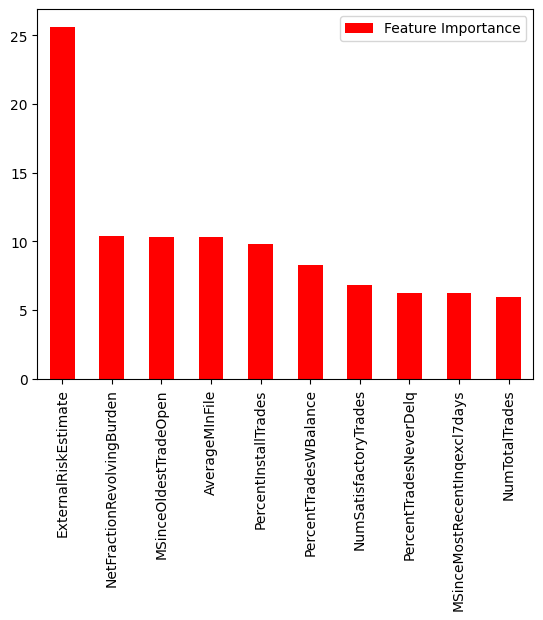

In [22]:
# Obtener la importancia de las características de los estimadores base (suponiendo que utiliza árboles de decisión como estimadores base)
feature_importances = np.mean(
    [tree.feature_importances_ for tree in bagging.estimators_], axis=0
)
feature_importances = np.concatenate(
    [feature_importances, np.zeros(len(columnas_xx) - len(feature_importances))]
)


bagging_featureImportance = pd.DataFrame(
    {"Feature Importance": feature_importances * 100}, index=columnas_xx
)

# Ordenar y trazar la importancia de las características
bagging_featureImportance.sort_values("Feature Importance", ascending=False).plot(
    kind="bar", color="red"
)

Hay overbagging

**Random Forest**

Hacemos validacion cruzada para elegir los mejores parámetros del modelo

In [23]:
parameters = {
    "n_estimators": [50, 100],  # Número de árboles en el bosque
    "max_depth": [None, 2, 5],  # Profundidad máxima de los árboles
    "min_samples_split": [
        2,
        5,
    ],  # Número mínimo de muestras requeridas para dividir un nodo interno
    "min_samples_leaf": [1, 2],
    "max_features": [
        0.1,
        0.5,
        1,
    ],  # Número mínimo de muestras requeridas para ser una hoja
    "bootstrap": [True],
    "ccp_alpha": [
        0.0,
        0.01,
        0.1,
    ],  # Si se deben usar muestras de arranque para construir árboles
}


# Creamos un clasificador Random Forest
rfc = RandomForestClassifier()

# Creamos un objeto GridSearchCV para buscar los mejores hiperparámetros
clf = GridSearchCV(rfc, parameters, cv=5)

# Ajustamos el modelo
clf.fit(X_train, y_train)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(clf.best_params_)

# Evaluamos el rendimiento del modelo en el conjunto de prueba
accuracy = clf.score(X_test, y_test)
print("Exactitud en el conjunto de prueba:", accuracy)

Mejores hiperparámetros encontrados:
{'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': 5, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Exactitud en el conjunto de prueba: 0.7338056680161943


Entrenamos el modelo óptimo

In [24]:
random_forest = RandomForestClassifier(**clf.best_params_)
random_forest.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, random_forest.predict(X_test))
accuracy_train = accuracy_score(y_train, random_forest.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["RandomForestClassifier"] = [
    random_forest,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.7532237673830594 test = 0.72165991902834


<Axes: >

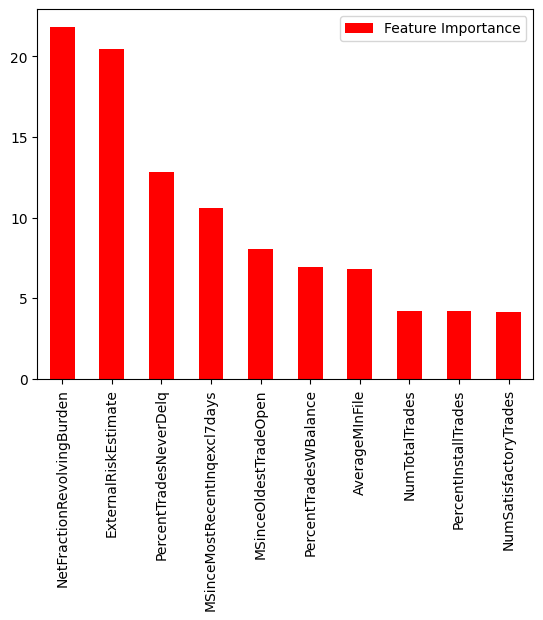

In [25]:
# Obtener la importancia de las características de los estimadores base (suponiendo que utiliza árboles de decisión como estimadores base)
feature_importances = np.mean(
    [tree.feature_importances_ for tree in random_forest.estimators_], axis=0
)

bagging_featureImportance = pd.DataFrame(
    {"Feature Importance": feature_importances * 100}, index=columnas_xx
)
# Crear un DataFrame para mostrar la importancia de las características
random_forest_featureImportance = pd.DataFrame(
    {"Feature Importance": feature_importances * 100}, index=columnas_xx
)

# Ordenar y trazar la importancia de las características
random_forest_featureImportance.sort_values("Feature Importance", ascending=False).plot(
    kind="bar", color="red"
)

**Boosting**

Hacemos validación cruzada para elegir el modelo óptimo

In [26]:
# Definimos los parámetros que queremos probar en el Gradient Boosting Classifier
parameters = {
    "learning_rate": [0.1],  # Tasa de aprendizaje
    "n_estimators": [100],  # Número de estimadores (árboles)
    "max_depth": [3, 5],  # Profundidad máxima del árbol
    "min_samples_split": [
        2,
        5,
    ],  # Número mínimo de muestras requeridas para dividir un nodo interno
    "min_samples_leaf": [1, 2],
    "ccp_alpha": [
        0.0,
        0.1,
        0.5,
    ],  # Número mínimo de muestras requeridas para ser una hoja
}


# Creamos un clasificador Gradient Boosting
gbc = GradientBoostingClassifier()

# Creamos un objeto GridSearchCV para buscar los mejores hiperparámetros
clf = GridSearchCV(gbc, parameters, cv=5)

# Ajustamos el modelo
clf.fit(X_train, y_train)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(clf.best_params_)

# Evaluamos el rendimiento del modelo en el conjunto de prueba
accuracy = clf.score(X_test, y_test)
print("Exactitud en el conjunto de prueba:", accuracy)

Mejores hiperparámetros encontrados:
{'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Exactitud en el conjunto de prueba: 0.7317813765182186


Entrenamos el modelo óptimo

In [27]:
gb = GradientBoostingClassifier(**clf.best_params_)
# If you want to try it out, you can change reuse most of previous codes to run it here!
gb.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, gb.predict(X_test))
accuracy_train = accuracy_score(y_train, gb.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["GradientBoostingClassifier"] = [
    gb,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.7780025284450063 test = 0.7317813765182186


**Support vector machines**

Hacemos validación cruzada para elegir la mejor combinación de hiperparámetros

In [28]:
# Definimos los parámetros que queremos probar en el SVC
parameters = {
    "C": [0.1, 1, 10],  # Parámetro de regularización
    "kernel": ["linear", "rbf", "poly"],  # Tipo de kernel
    "gamma": ["scale", "auto"],  # Coeficiente del kernel (solo para 'rbf' y 'poly')
    "degree": [2, 3, 4],
    # Grado del polinomio (solo para 'poly')
}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados:")
print(clf.best_params_)
accuracy = clf.score(X_test, y_test)
print("accuracy en el conjunto de prueba:", accuracy)

Mejores hiperparámetros encontrados:
{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
accuracy en el conjunto de prueba: 0.7267206477732794


In [29]:
clf.best_params_["probability"] = True  # Para poder pintar la curva roc

In [30]:
sv_rbf = SVC(**clf.best_params_)
sv_rbf.fit(X_train, y_train)
accuracy_test = accuracy_score(y_test, sv_rbf.predict(X_test))
accuracy_train = accuracy_score(y_train, sv_rbf.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["SVC"] = [sv_rbf, accuracy_train, accuracy_test]

Accuracy, train = 0.7428571428571429 test = 0.7267206477732794


**Red neuronal**

In [31]:
parameters = {
    "hidden_layer_sizes": [
        (1, 1),
        (1,),
        (1, 3),
        (10, 10),
    ],  # Tamaños de las capas ocultas
    "activation": ["relu", "tanh", "logistic"],  # Funciones de activación
    "alpha": [0.001, 0.01],  # Parámetro de regularización
}

mlp = MLPClassifier(max_iter=1000)


clf = GridSearchCV(mlp, parameters, cv=5)


clf.fit(X_train, y_train)


print("Mejores hiperparámetros encontrados:")
print(clf.best_params_)

accuracy = clf.score(X_test, y_test)
print("accuracy en el conjunto de prueba:", accuracy)

C:\Users\mange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores hiperparámetros encontrados:
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (1,)}
accuracy en el conjunto de prueba: 0.7165991902834008


In [32]:
# Crear y entrenar la red neuronal
rnn = MLPClassifier(
    **clf.best_params_
)  # early stopping para que pare cuando la puntuacion de validacion no mejora
rnn.fit(X_train, y_train)


accuracy_test = accuracy_score(y_test, rnn.predict(X_test))
accuracy_train = accuracy_score(y_train, rnn.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")

diccionario_performance["MLPClassifier"] = [rnn, accuracy_train, accuracy_test]

Accuracy, train = 0.7390644753476612 test = 0.7196356275303644


3. Creativity and innovation (1.0 pts)

Entrenamos un clasificador xgboost. Es parecido a bagging pero en general rinde mejor y es más rápido. 

Primero hacemos cross validation

In [33]:
# Definir los hiperparámetros a probar
param_grid = {
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.5, 0.7, 0.9],
}

# Inicializar el clasificador XGBoost
xgb_model = xgb.XGBClassifier()

# Inicializar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, cv=5, scoring="accuracy"
)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Evaluar el mejor modelo
print("Reporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}
Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72       484
         1.0       0.73      0.74      0.74       504

    accuracy                           0.73       988
   macro avg       0.73      0.73      0.73       988
weighted avg       0.73      0.73      0.73       988



Entrenamos el modelo óptimo

In [34]:
# Entrenar el modelo XGBoost
xgb_model = xgb.XGBClassifier(**grid_search.best_params_)
xgb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Evaluar el modelo
accuracy_test = accuracy_score(y_test, xgb_model.predict(X_test))
accuracy_train = accuracy_score(y_train, xgb_model.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")

diccionario_performance["XGBClassifier"] = [xgb_model, accuracy_train, accuracy_test]

Accuracy, train = 0.765865992414665 test = 0.7267206477732794


También podemos entrenar un LGBMClassifier, que en teoría funciona mejor para datos con más dimensiones

In [35]:
lgb_model = lgb.LGBMClassifier()

# Definir los parámetros a ajustar y sus valores
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "num_leaves": [20, 30, 40],
    "max_depth": [5, 10, 15],
}

# Inicializar GridSearchCV
grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring="accuracy")

# Entrenar GridSearchCV en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

[LightGBM] [Info] Number of positive: 1614, number of negative: 1550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 3164, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510114 -> initscore=0.040461
[LightGBM] [Info] Start training from score 0.040461
[LightGBM] [Info] Number of positive: 1614, number of negative: 1550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 3164, number of used features: 10
[LightGBM] [Info] [binary:Bo

In [36]:
# Entrenar un nuevo modelo LightGBM con los mejores parámetros encontrados
best_lgb_model = lgb.LGBMClassifier(**best_params)
best_lgb_model.fit(X_train, y_train)

# Evaluar el modelo en los conjuntos de entrenamiento y prueba
accuracy_train = accuracy_score(y_train, best_lgb_model.predict(X_train))
accuracy_test = accuracy_score(y_test, best_lgb_model.predict(X_test))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["LGBMClassifier"] = [
    best_lgb_model,
    accuracy_train,
    accuracy_test,
]

[LightGBM] [Info] Number of positive: 2017, number of negative: 1938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 3955, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509987 -> initscore=0.039955
[LightGBM] [Info] Start training from score 0.039955
Accuracy, train = 0.7737041719342604 test = 0.7155870445344129


También podemos hacer una combinación de modelos

In [37]:
# Inicializar los modelos base
rf_model = RandomForestClassifier(n_estimators=100, random_state=11)
knn_model = KNeighborsClassifier()
svc_model = SVC()

# Inicializar el modelo Stacking
stacking_model = StackingClassifier(
    estimators=[("rf", rf_model), ("knn", knn_model), ("svc", svc_model)],
    final_estimator=MLPClassifier(
        hidden_layer_sizes=(100,), max_iter=1000, random_state=42
    ),
    cv=5,
)

# Entrenar el modelo Stacking
stacking_model.fit(X_train, y_train)


# Evaluar el modelo
accuracy_test = accuracy_score(y_test, stacking_model.predict(X_test))
accuracy_train = accuracy_score(y_train, stacking_model.predict(X_train))
print(f"Accuracy, train = {accuracy_train} test = {accuracy_test}")
diccionario_performance["StackingClassifier"] = [
    stacking_model,
    accuracy_train,
    accuracy_test,
]

Accuracy, train = 0.8300884955752212 test = 0.7206477732793523


***CARGA DE MODELOS***

Cargamos todos los modelos en memoria para evitar tener que entrenarlos constantemente 

In [38]:
nombre_zip = "modelos.zip"
nombre_carpeta = "modelos"


with zipfile.ZipFile(nombre_zip, "w") as zip_file:

    for modelo_name, [
        modelo,
        train_accuracy,
        test_accuracy,
    ] in diccionario_performance.items():

        with zip_file.open(f"{nombre_carpeta}/{modelo_name}.pkl", "w") as model_file:
            joblib.dump(modelo, model_file)

        contenido_archivo = f"{train_accuracy} {test_accuracy}"

        with zip_file.open(f"{nombre_carpeta}/{modelo_name}.txt", "w") as txt_file:
            txt_file.write(contenido_archivo.encode())

***Lectura de modelos***

Leemos todos los modelos (ejecutar a partir de aquí para omitir fase de entrenamiento)
(importar librerías y leer datos antes)

In [61]:
archivo_zip_modelos = "modelos.zip"
nombre_carpeta = "modelos"


diccionario_performance = {}


with zipfile.ZipFile(archivo_zip_modelos, "r") as zip_file:

    archivos_en_zip = zip_file.namelist()

    for archivo in archivos_en_zip:

        if archivo.startswith(f"{nombre_carpeta}/") and archivo.endswith(".pkl"):

            nombre_modelo = os.path.splitext(os.path.basename(archivo))[0]

            with zip_file.open(archivo, "r") as model_file:
                modelo_cargado = joblib.load(model_file)

            archivo_txt = f"{os.path.splitext(archivo)[0]}.txt"

            with zip_file.open(archivo_txt, "r") as txt_file:
                contenido_txt = txt_file.read().decode()

            lineas = contenido_txt.split(" ")
            train_accuracy = float(lineas[0])
            test_accuracy = float(lineas[1])

            diccionario_performance[nombre_modelo] = [
                modelo_cargado,
                train_accuracy,
                test_accuracy,
            ]

2. Comparative analysis of the fitted models. (2.5 pts)

Acuraccy en train y en test para cada modelo

In [62]:
performance_df = pd.DataFrame.from_dict(
    diccionario_performance, orient="index", columns=["modelo", "acc_train", "acc_test"]
)
print(performance_df)

                                                                          modelo  \
KNeighborsClassifier                   KNeighborsClassifier(n_neighbors=33, p=1)   
LogisticRegression             LogisticRegression(C=0.01, max_iter=1000, solv...   
LinearDiscriminantAnalysis                          LinearDiscriminantAnalysis()   
QuadraticDiscriminantAnalysis       QuadraticDiscriminantAnalysis(reg_param=0.6)   
GaussianNB                                                          GaussianNB()   
DecisionTreeClassifier         DecisionTreeClassifier(max_depth=3, random_sta...   
BaggingClassifier              (DecisionTreeClassifier(random_state=811032233...   
RandomForestClassifier         (DecisionTreeClassifier(max_depth=5, max_featu...   
GradientBoostingClassifier     ([DecisionTreeRegressor(criterion='friedman_ms...   
SVC                            SVC(C=0.1, degree=2, gamma='auto', probability...   
MLPClassifier                  MLPClassifier(activation='logistic', alpha=0.

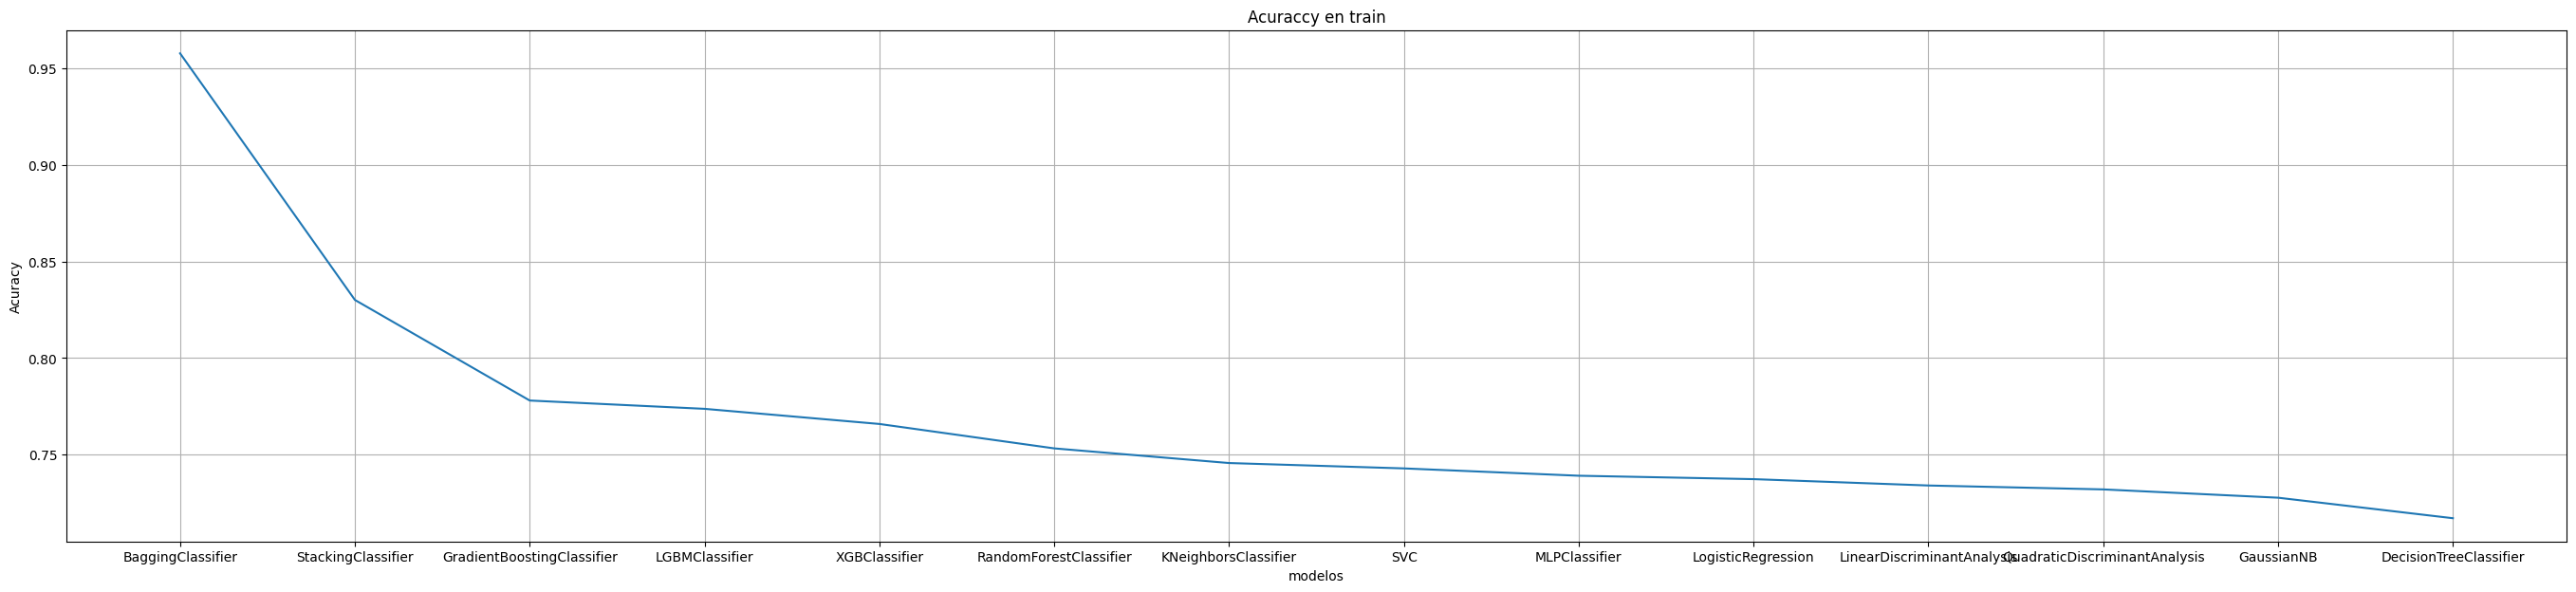

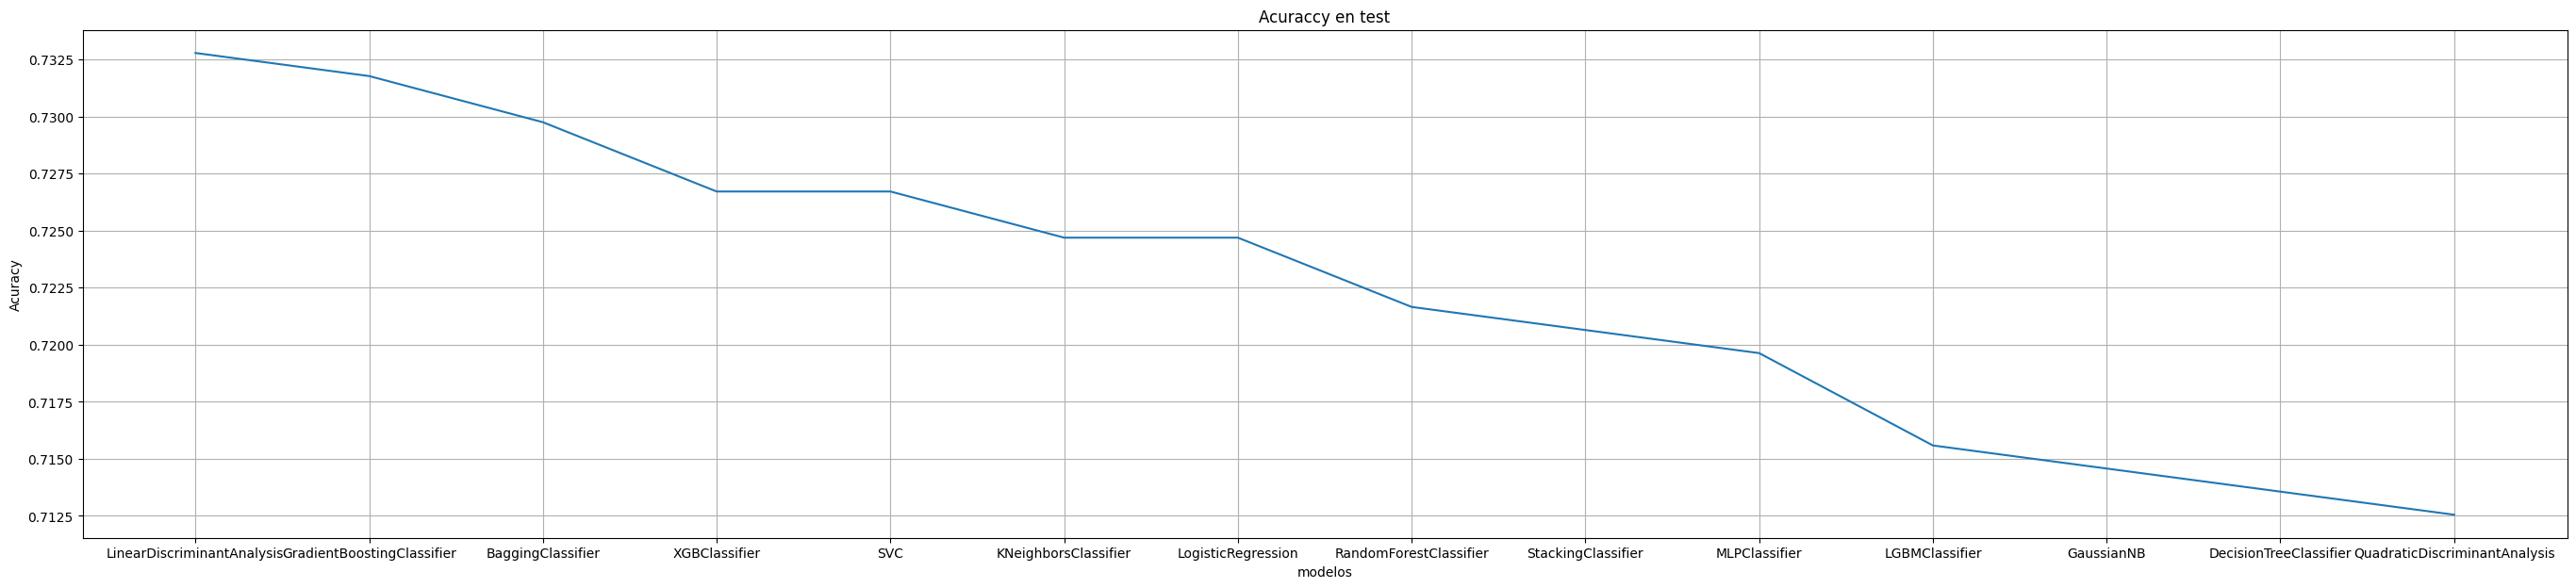

In [63]:
# Trazar la línea
performance_df = performance_df.sort_values(by="acc_train", ascending=False)
plt.figure(figsize=(34, 7))
plt.plot(performance_df.index, performance_df["acc_train"])
# Personalizar el gráfico
plt.title("Acuraccy en train")
plt.xlabel("modelos")
plt.ylabel("Acuracy")
plt.grid(True)
# Trazar la línea
performance_df = performance_df.sort_values(by="acc_test", ascending=False)
plt.figure(figsize=(34, 7))
plt.plot(performance_df.index, performance_df["acc_test"])
# Personalizar el gráfico
plt.title("Acuraccy en test")
plt.xlabel("modelos")
plt.ylabel("Acuracy")
plt.grid(True)

Curva roc para cada modelo

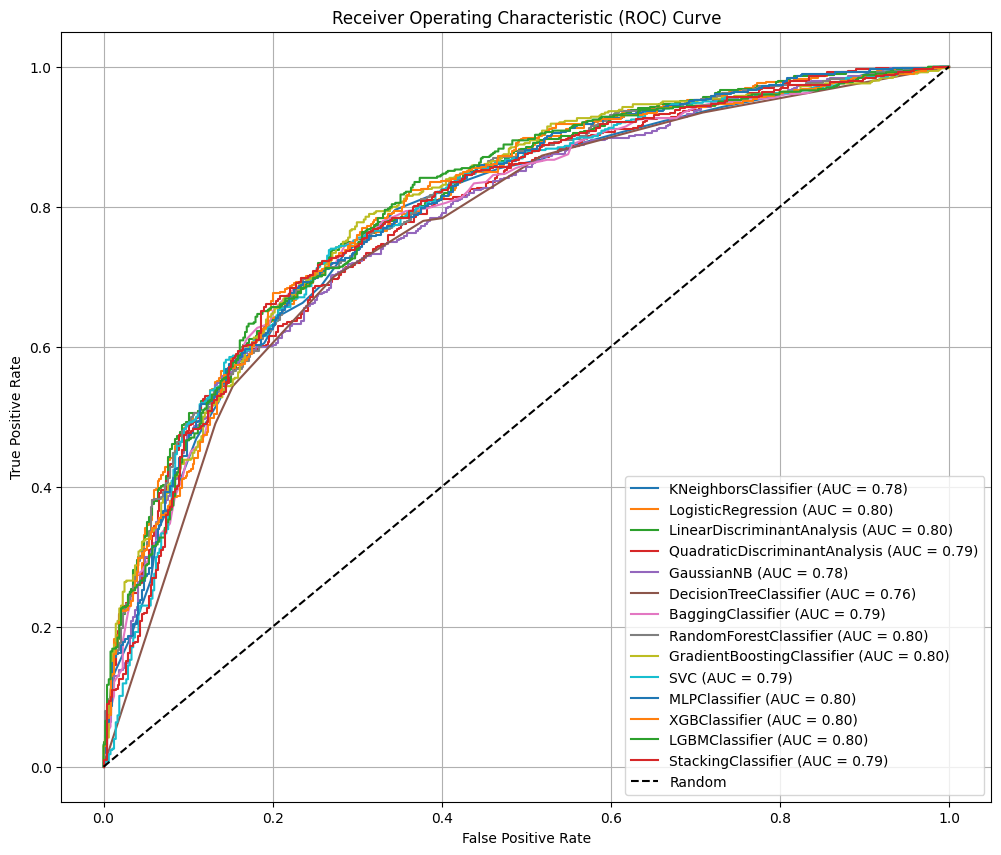

In [64]:
# Crear la figura
plt.figure(figsize=(18 - 6, 16 - 6))

# Iterar sobre cada modelo en el diccionario de rendimiento
for modelo, [clf, train_accuracy, test_accuracy] in diccionario_performance.items():
    # Calcular las probabilidades de predicción para la clase positiva
    y_probabilities = clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

    # Calcular el área bajo la curva ROC (AUC)
    auc = roc_auc_score(y_test, y_probabilities)

    # Dibujar la curva ROC
    plt.plot(fpr, tpr, label=f"{modelo} (AUC = {auc:.2f})")

# Dibujar la línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], "k--", label="Random")

# Añadir etiquetas y título
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Mostrar la gráfica
plt.show()

Matriz de confusión para cada modelo

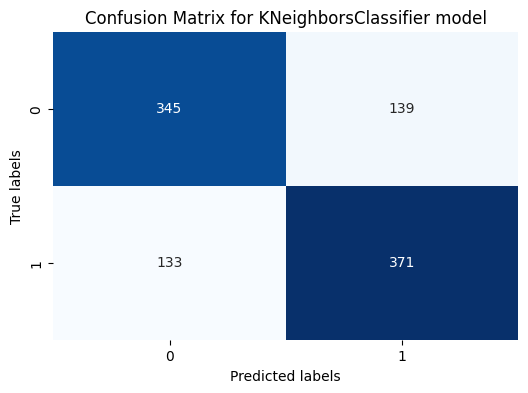

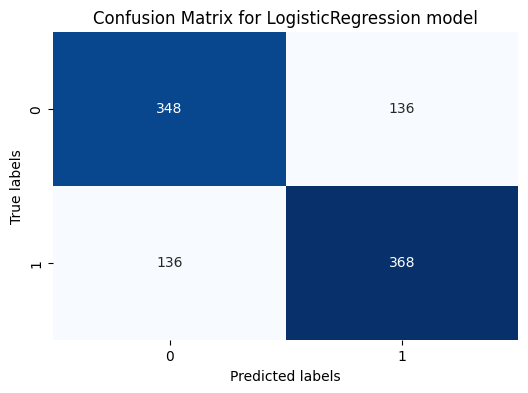

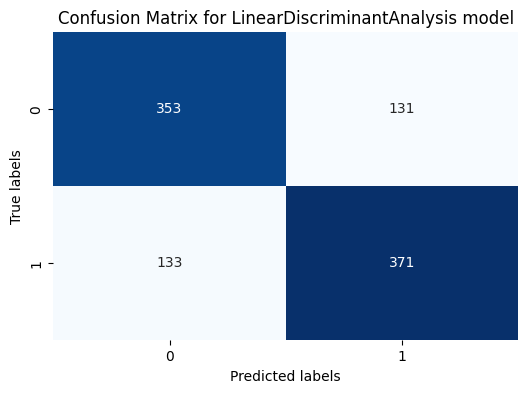

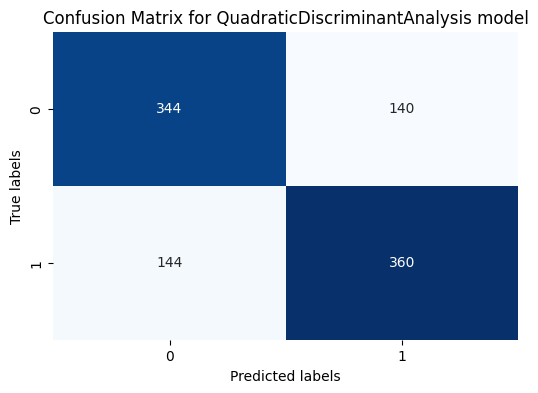

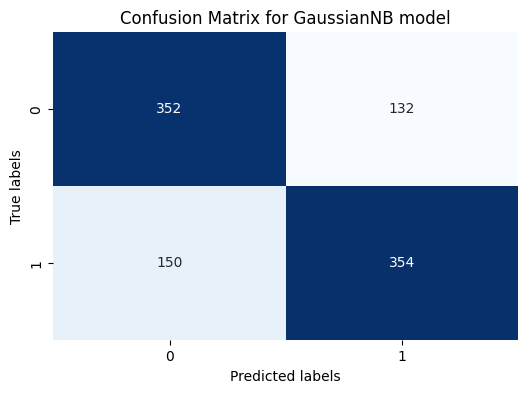

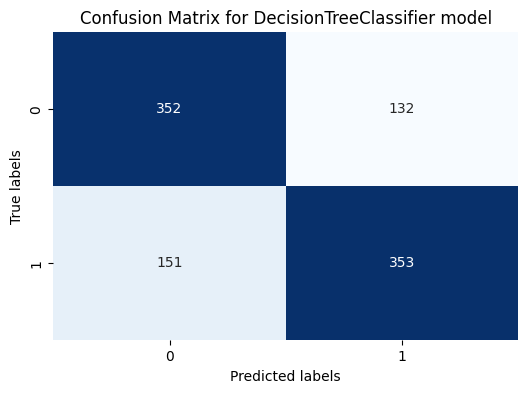

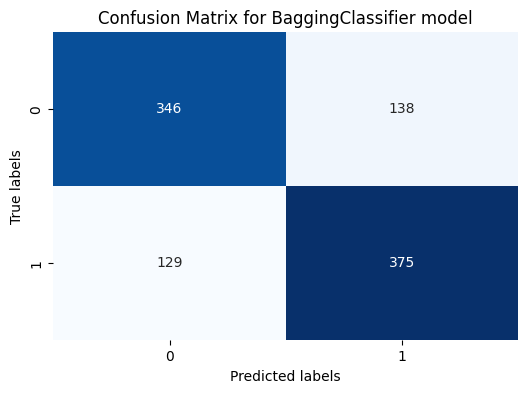

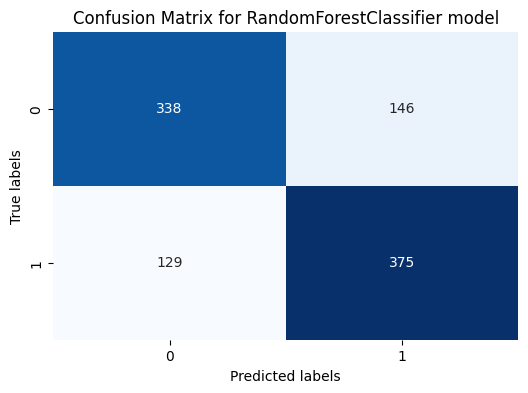

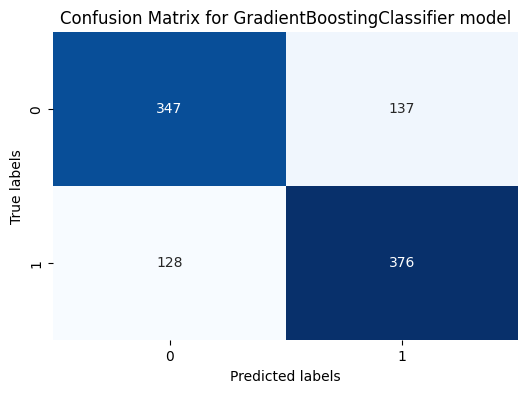

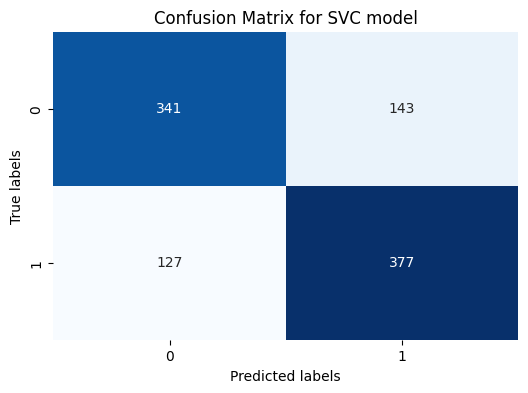

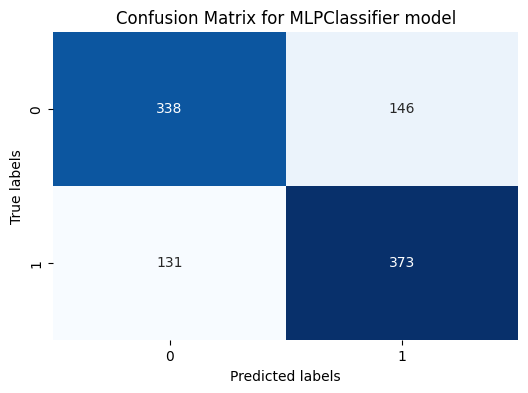

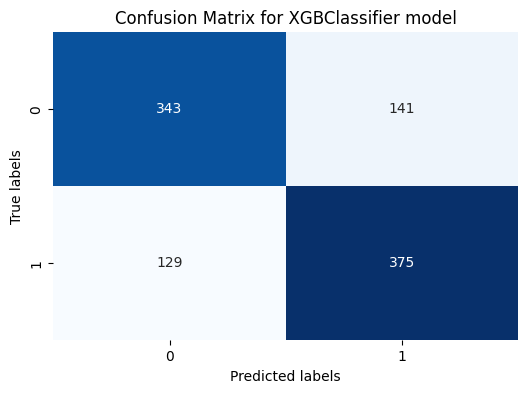

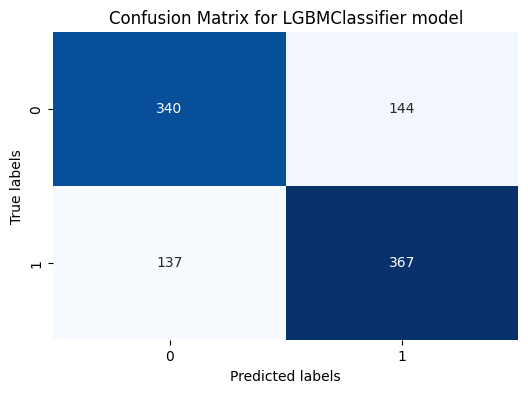

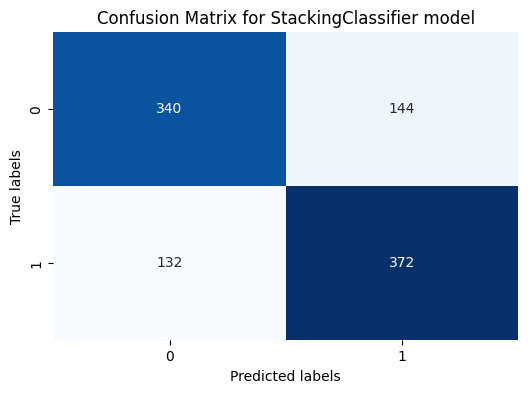

In [65]:
for modelo, [clf, train_accuracy, test_accuracy] in diccionario_performance.items():
    # Realizar predicciones en el conjunto de prueba
    y_pred = clf.predict(X_test)

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Crear una figura y un eje para la matriz de confusión
    plt.figure(figsize=(6, 4))

    # Usar seaborn para dibujar la matriz de confusión como un mapa de calor
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

    # Añadir etiquetas y título
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix for {modelo} model")

    # Mostrar la matriz de confusión
    plt.show()

Curvas precision-recall

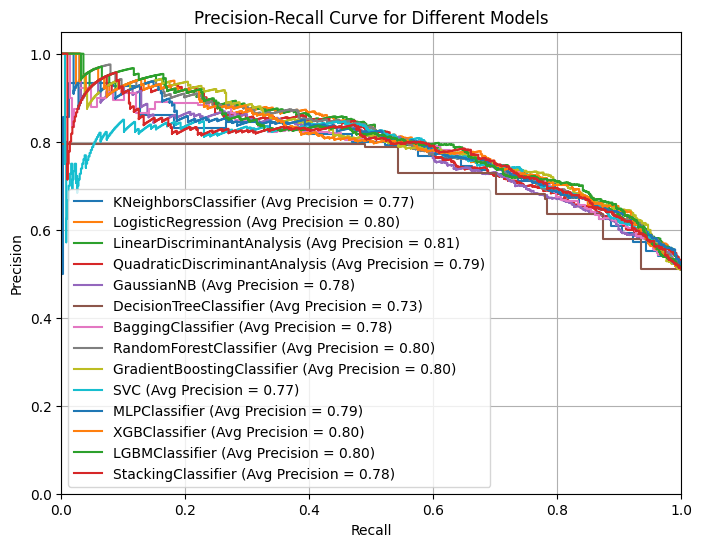

In [66]:


# Crear una figura para la curva de precisión-recall
plt.figure(figsize=(8, 6))

# Iterar sobre cada modelo en el diccionario de rendimiento
for modelo, [clf, train_accuracy, test_accuracy] in diccionario_performance.items():
    # Calcular las probabilidades de predicción para la clase positiva
    y_probabilities = clf.predict_proba(X_test)[:, 1]

    # Calcular la curva de precisión-recall
    precision, recall, _ = precision_recall_curve(y_test, y_probabilities)

    # Calcular el promedio de precisión
    average_precision = average_precision_score(y_test, y_probabilities)

    # Tracer la curva de precisión-recall
    plt.step(
        recall,
        precision,
        where="post",
        label=f"{modelo} (Avg Precision = {average_precision:.2f})",
    )

# Añadir etiquetas y título
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall Curve for Different Models")
plt.grid(True)
plt.legend()
plt.show()

Histogramas de las probabilidades predichas

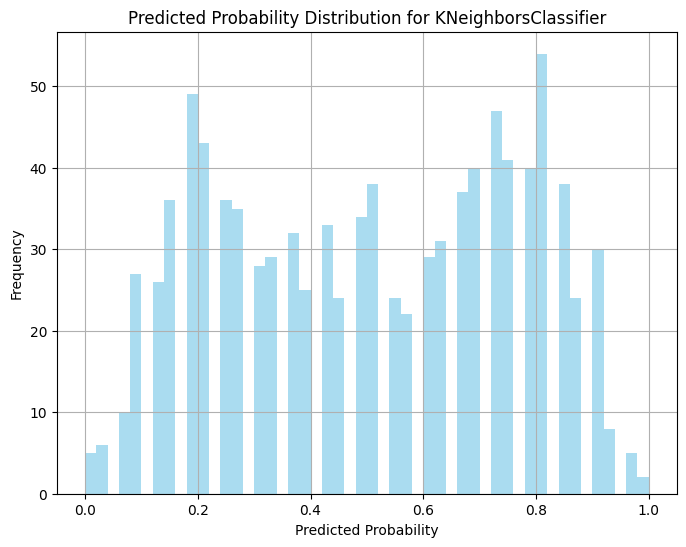

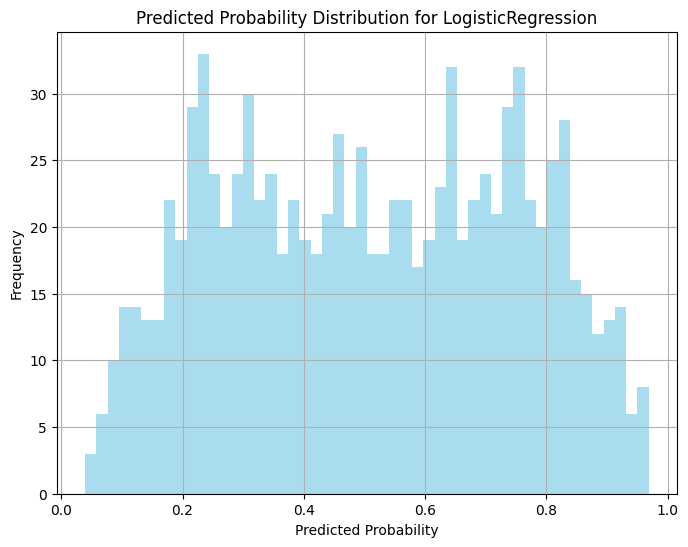

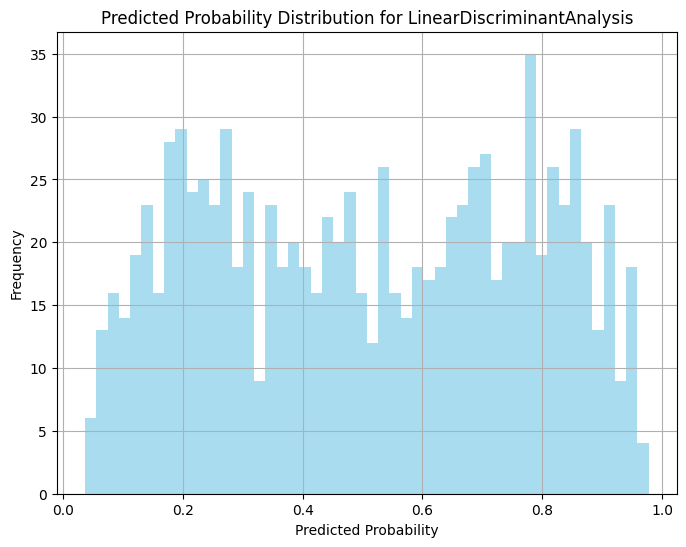

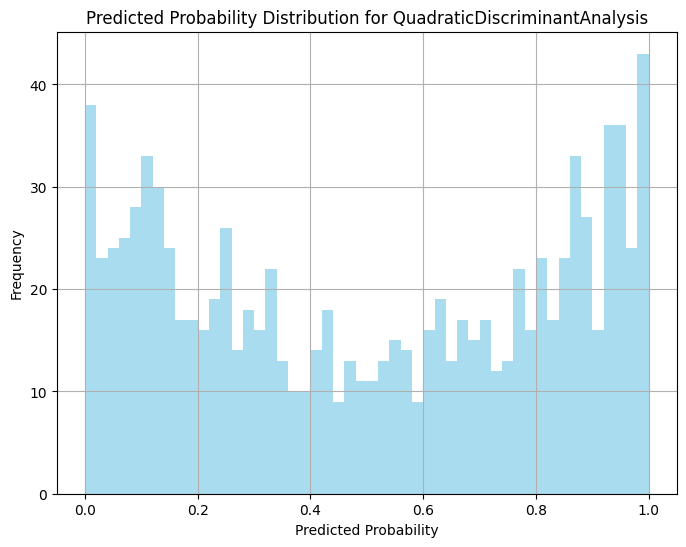

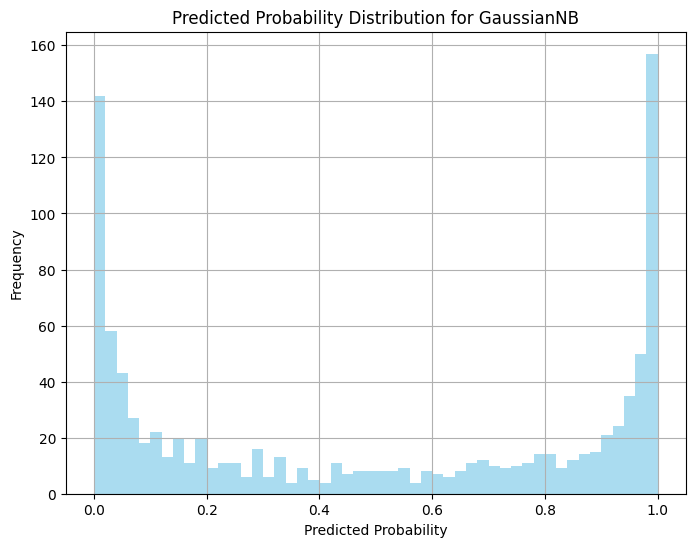

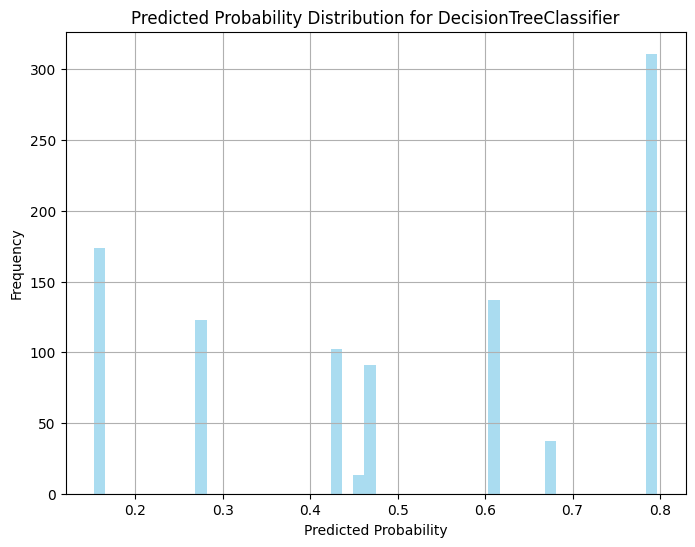

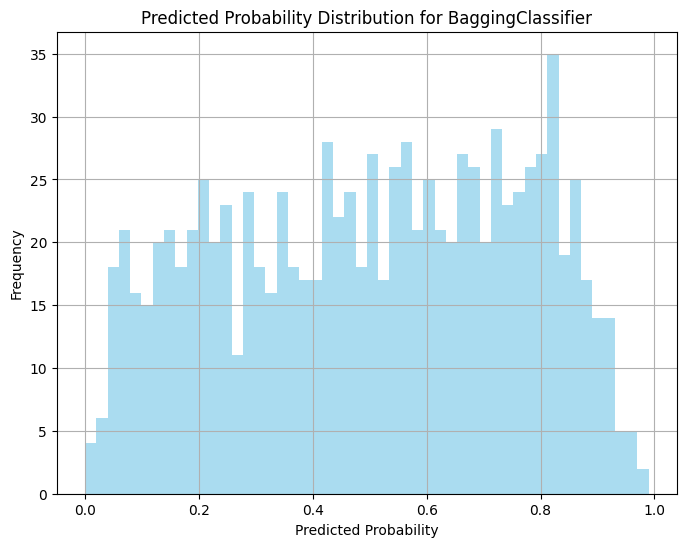

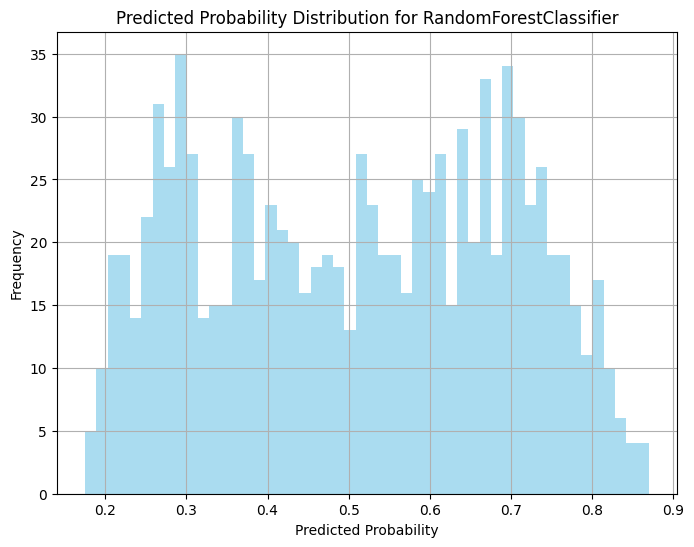

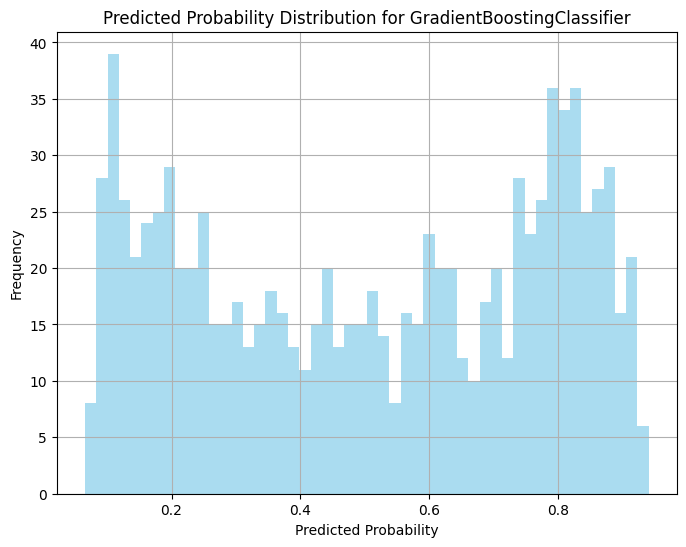

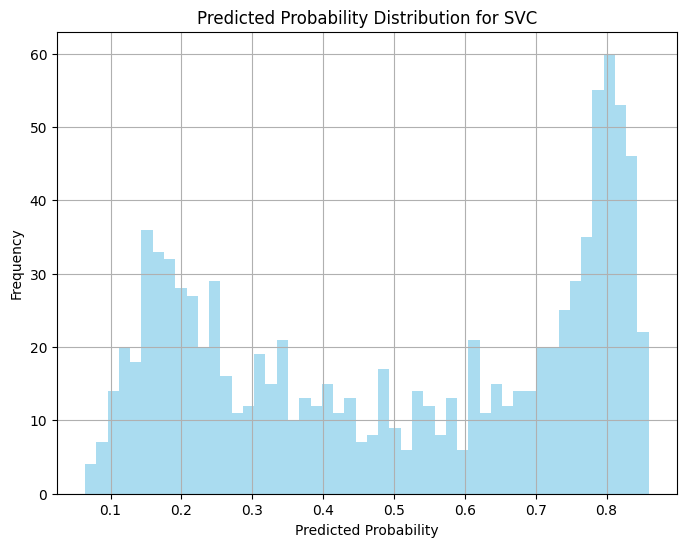

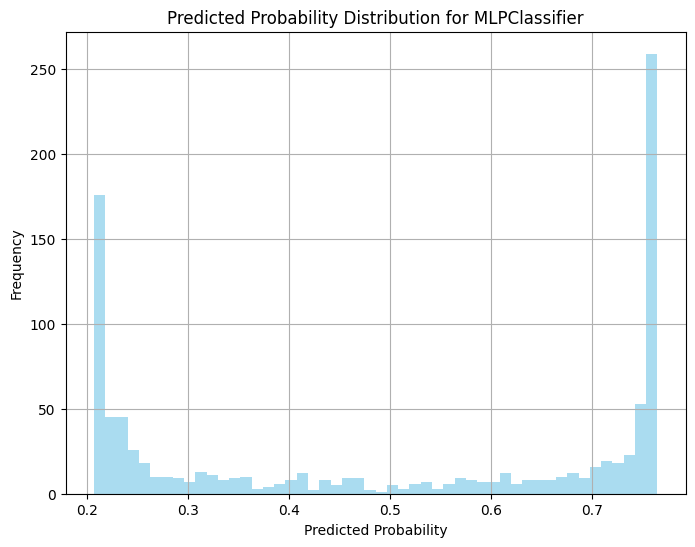

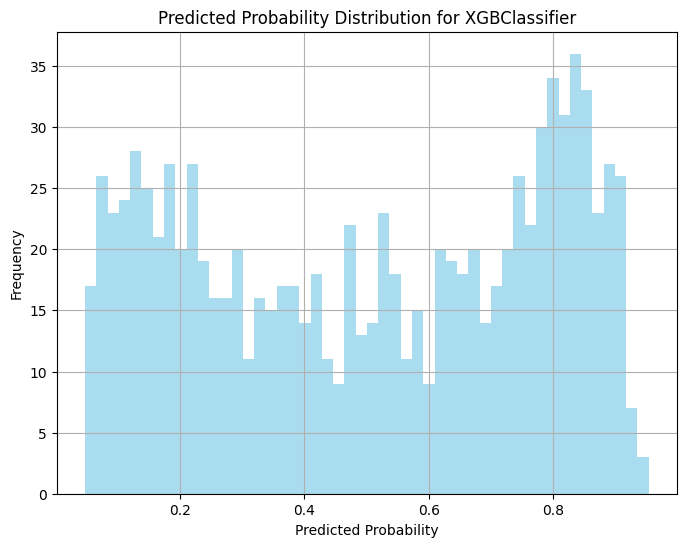

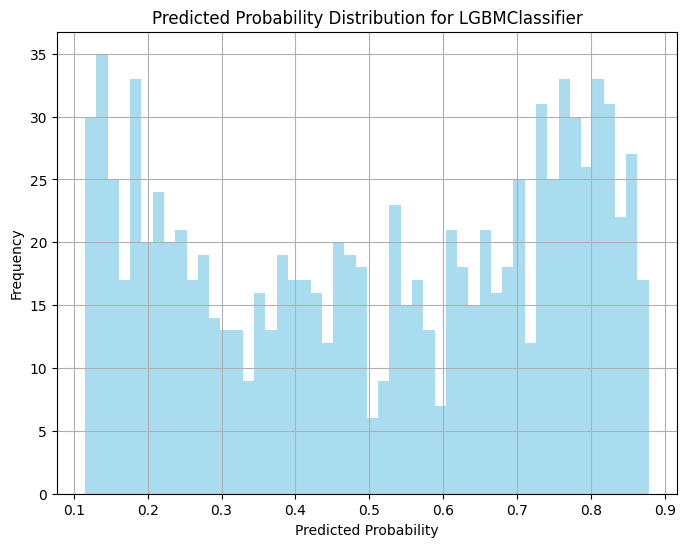

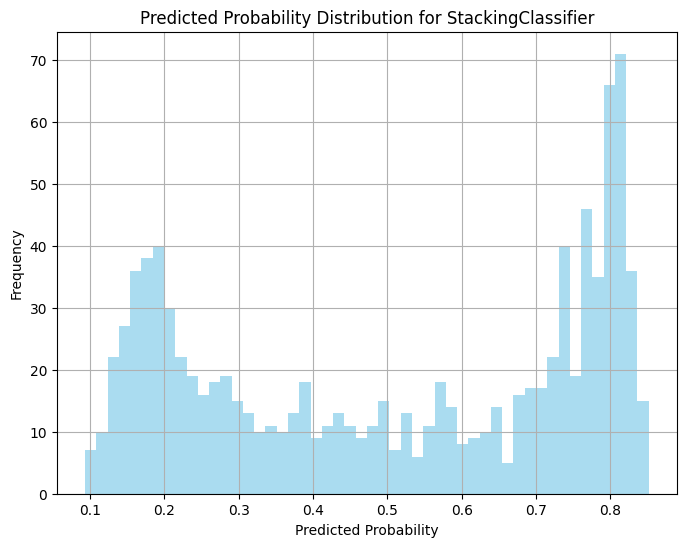

In [67]:
# Iterar sobre cada modelo en el diccionario de rendimiento
for modelo, [clf, train_accuracy, test_accuracy] in diccionario_performance.items():
    # Calcular las probabilidades de predicción para la clase positiva
    y_probabilities = clf.predict_proba(X_test)[:, 1]

    # Crear una figura para el histograma de probabilidades predichas
    plt.figure(figsize=(8, 6))

    # Tracer el histograma de las probabilidades predichas
    plt.hist(y_probabilities, bins=50, color="skyblue", alpha=0.7)

    # Añadir etiquetas y título al histograma
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.title(f"Predicted Probability Distribution for {modelo}")
    plt.grid(True)

    # Mostrar el histograma
    plt.show()